In [22]:
import torch
from torch import nn
import torchvision.transforms as T
from presnet import PResNet
from hybrid_encoder import HybridEncoder
from rtdetrv2_decoder import RTDETRTransformerv2
from rtdetr_postprocessor import RTDETRPostProcessor
from matcher import HungarianMatcher
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import os

from ema import ModelEMA
from warmup import LinearWarmup

In [23]:
num_classes = 1

In [24]:
# Setup Feature Extractor
presnet = PResNet(depth= 18,
                  variant = 'd',
                  freeze_at = -1,
                  return_idx = [1, 2, 3],
                  num_stages = 4,
                  freeze_norm = False,
                  pretrained = True, 
                  act="leaky_relu",)

Load PResNet18 state_dict


In [25]:
encoder = HybridEncoder(  in_channels = [128, 256, 512],
                          feat_strides = [8, 16, 32],
                          # intra
                          hidden_dim = 256,
                          use_encoder_idx = [2],
                          num_encoder_layers = 2,
                          nhead = 8,
                          dim_feedforward = 1024,
                          dropout = 0.,
                          enc_act = 'gelu' ,
                          # cross
                          expansion = 0.5,
                          depth_mult = 1,
                          act = 'silu')

In [26]:
decoder = RTDETRTransformerv2(feat_channels = [256, 256, 256],
                              feat_strides = [8, 16, 32],
                              hidden_dim = 256,
                              num_levels = 3,
                              num_layers = 3,
                              num_queries = 300,
                              num_denoising = 200,
                              label_noise_ratio = 0.5,
                              box_noise_scale = 1.0, # 1.0 0.4
                              eval_idx = -1,
                              # NEW
                              num_points = [4, 4, 4], # [3,3,3] [2,2,2]
                              cross_attn_method = 'default', # default, discrete
                              query_select_method = 'agnostic', # default, agnostic 
                              num_classes=1,
                              activation="relu",
                              dropout=0
                              )

In [27]:
postprocessor = RTDETRPostProcessor()

In [28]:
# Loading the dataset
from dataset import PersonDataset
from torch.utils.data import random_split, DataLoader

root_dir = '/media/enrique/Extreme SSD/person'
sequence_list = [f'person-{i}' for i in range(1, 21)]
sequence_list = ["person-9"]
dataset = PersonDataset(root_dir=root_dir, sequence_list=sequence_list, img_transform_size=(640, 640), template_transform_size=(256, 256), max_num_templates=10, max_detections = 300)

batch_size = 2
# Optionally, create DataLoader objects for the training and validation sets
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [29]:
data_iter = iter(data_loader)

# Get a batch of data (this returns a batch of inputs and possibly targets)
data_batch = next(data_iter)

In [30]:
presnet.cuda()
encoder.cuda()
decoder.cuda()

RTDETRTransformerv2(
  (input_proj): ModuleList(
    (0-2): 3 x Sequential(
      (conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (dropout1): Dropout(p=0, inplace=False)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (cross_attn): MSDeformableAttention(
          (sampling_offsets): Linear(in_features=256, out_features=192, bias=True)
          (attention_weights): Linear(in_features=256, out_features=96, bias=True)
          (value_proj): Linear(in_features=256, out_features=256, bias=True)
          (output_proj): Linear(in_features=256, out_features=256, bias=True)
    

/usr/lib/python3/dist-packages/matplotlib/cm.py:440: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


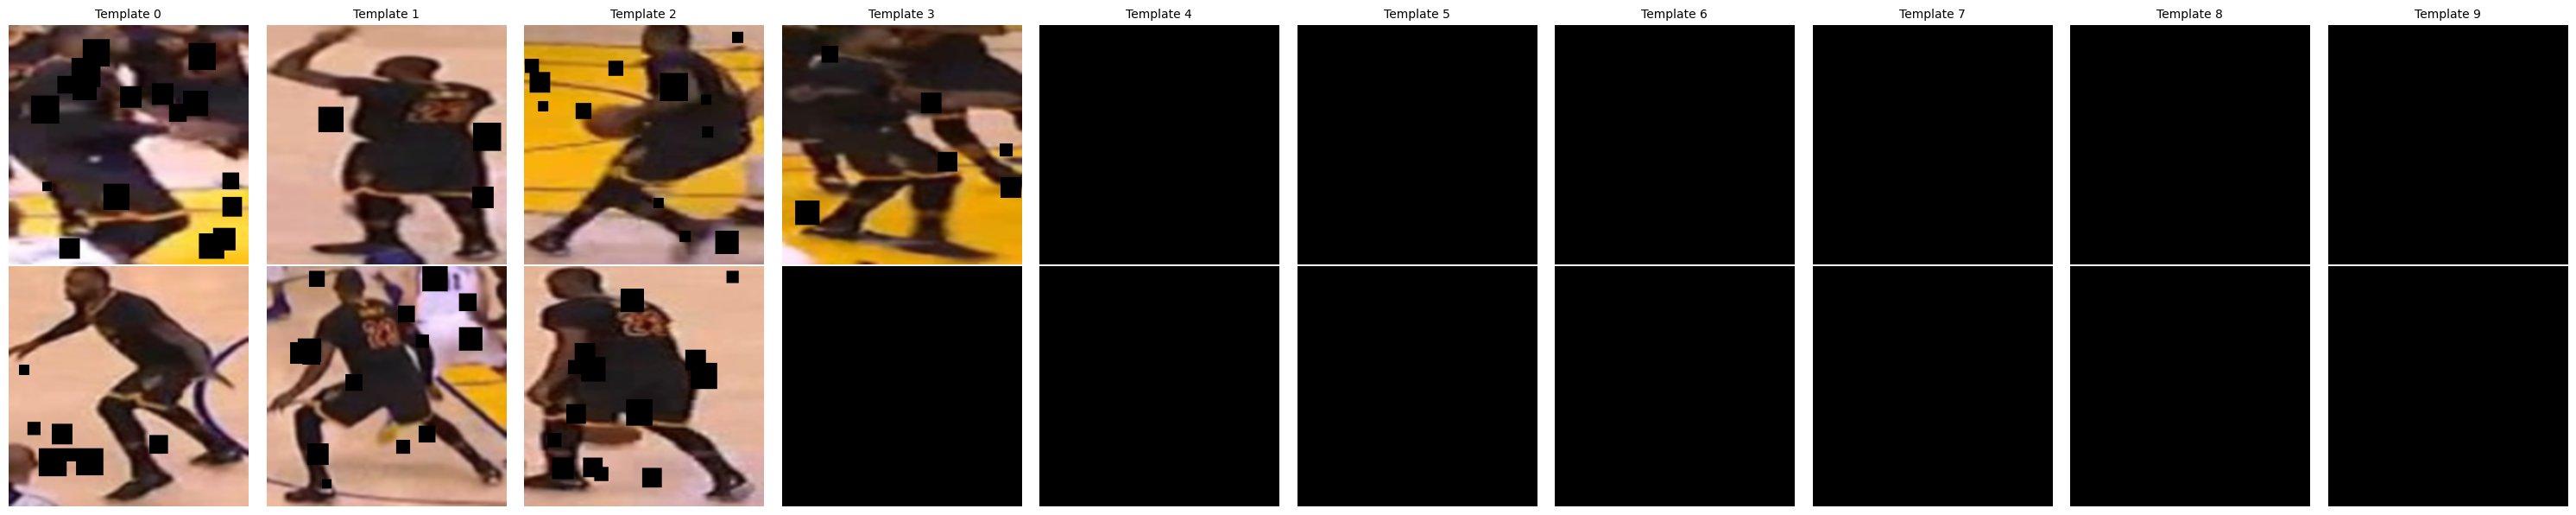

In [31]:

tensor = data_batch["templates"]
batch_size = tensor.shape[0]
num_templates = tensor.shape[1]

# Create a figure with multiple subplots: rows = batch_size, cols = num_templates
fig, axs = plt.subplots(batch_size, num_templates, figsize=(num_templates * 3, batch_size * 3))

# Loop over the batches and templates
for i in range(batch_size):
    for j in range(num_templates):
        # Extract the corresponding template image from the tensor
        img_tensor = tensor[i, j]

        # Permute to [width, height, channels] for matplotlib if it's RGB
        img_tensor = img_tensor.permute(1, 2, 0)

        # Normalize the image tensor for better visualization
        img_tensor = (img_tensor - img_tensor.min()) / (img_tensor.max() - img_tensor.min())

        # Plot the image on the subplot (i-th row, j-th column)
        axs[i, j].imshow(img_tensor)
        axs[i, j].axis('off')  # Remove the axis for a cleaner look

        # Set titles for rows and columns
        if i == 0:
            axs[i, j].set_title(f'Template {j}', fontsize=10)
        if j == 0:
            axs[i, j].set_ylabel(f'Batch {i}', fontsize=10)

# Adjust the layout for better spacing
plt.tight_layout()
plt.show()

In [32]:
template_imgs = data_batch["templates"].cuda()
num_templates = data_batch["num_templates"].cuda()

In [33]:
# Get the last feature layer from the feature extractor for each template
# presnet(...)[0] = lower level features, 
# presnet(...)[1] = higher level features,
# presnet(...)[2] = mid level features,

templates_feats = []
for i in range(data_batch["templates"].shape[0]):
    templates_feats.append(presnet(template_imgs[i])[-2].unsqueeze(0))
templates_feats = torch.cat(templates_feats)

print(templates_feats.shape)

# Get the Image features
img_feats = presnet(data_batch["img"].cuda())
for img_feat in img_feats:
    print(img_feat.shape)

torch.Size([2, 10, 256, 16, 16])
torch.Size([2, 128, 80, 80])
torch.Size([2, 256, 40, 40])
torch.Size([2, 512, 20, 20])


In [34]:
# Warmuprun
# encoder_feats, template_feats, attentions = encoder(img_feats, templates_feats, num_templates)


In [35]:
# decoder.eval()
# decoder_outs, attentions = decoder(encoder_feats, template_feats, num_templates)

In [36]:
# Convert tensor to numpy array for visualization
# for attn_weights in attentions:
    
#     visual_mask = attn_weights[0].detach().cpu().numpy()

#     print("attn_weights.shape", attn_weights.shape)

#     print("is there something", attn_weights[0].sum())

#     # Plot the attention mask using matplotlib
#     plt.figure(figsize=(8, 6))
#     plt.imshow(visual_mask, cmap="Blues")
#     plt.colorbar(label="Mask Value")
#     plt.title('Attention Mask Visualization')
#     plt.xlabel('Key Sequence Positions')
#     plt.ylabel('Query Sequence Positions')
#     plt.show()